In [12]:
import tensorflow as tf
keras = tf.keras
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [13]:
# %run ../src/acc_df.py
# Ac = Acc_data('../data/cleaned/coll_coord.csv')
# acc = Ac.get_all_coll() #['']

### 1. Turn it into a time series of weeks

In [14]:
week_numbers = pd.read_csv('../../data/cleaned/weekseries_05_18.csv')

In [15]:
week_numbers.head(2),week_numbers.tail(2)

(           ds  acc_nr
 0  2005-01-02     275
 1  2005-01-09     308,              ds  acc_nr
 729  2018-12-23     234
 730  2018-12-30     150)

In [80]:
acc_nr_bw = week_numbers.acc_nr.values #[:100]
acc_nr_bw

array([275, 308, 209, 284, 268, 277, 260, 248, 252, 279, 292, 290, 286,
       330, 306, 327, 286, 301, 270, 283, 370, 298, 285, 342, 313, 357,
       232, 300, 319, 294, 324, 330, 259, 282, 301, 288, 302, 301, 285,
       328, 305, 296, 323, 340, 395, 322, 311, 271, 303, 302, 298, 348,
       267, 299, 350, 281, 336, 323, 309, 294, 273, 268, 294, 262, 274,
       261, 350, 301, 278, 273, 271, 251, 310, 279, 339, 286, 296, 270,
       290, 280, 297, 276, 285, 285, 307, 292, 284, 279, 274, 271, 340,
       288, 307, 265, 347, 286, 410, 368, 306, 285, 286, 251, 301, 292,
       235, 307, 322, 270, 249, 276, 250, 257, 261, 261, 271, 266, 303,
       260, 262, 277, 244, 261, 307, 255, 287, 269, 306, 313, 262, 283,
       317, 288, 275, 349, 253, 287, 241, 303, 269, 256, 296, 276, 252,
       319, 317, 259, 344, 294, 261, 287, 350, 227, 290, 273, 286, 309,
       185, 271, 251, 273, 246, 265, 263, 246, 222, 233, 231, 302, 255,
       248, 267, 263, 274, 258, 269, 253, 255, 281, 228, 271, 27

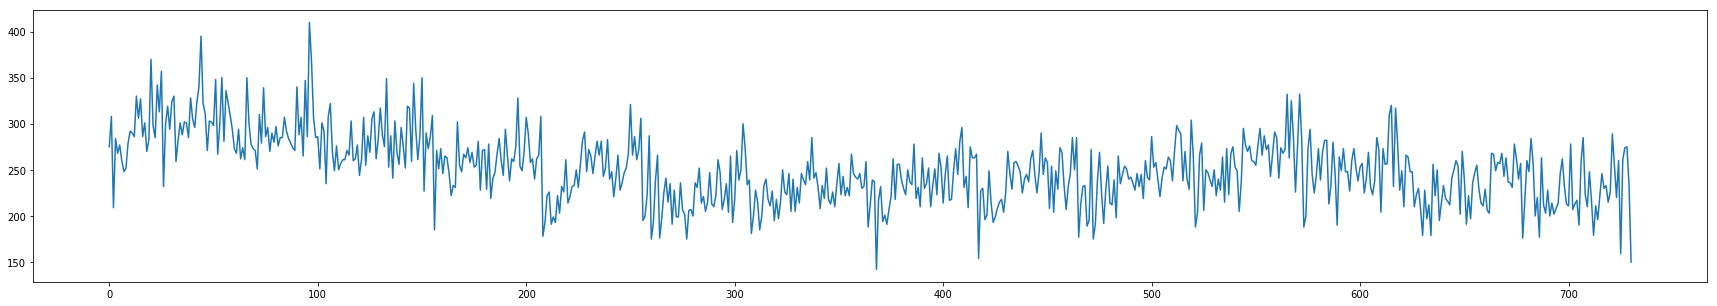

In [17]:
fig, ax = plt.subplots(figsize=(30,5))
ax.plot(week_numbers.index.values, acc_nr_bw)

#### Windowize and split

In [18]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

In [19]:
# windowize_data(week_numbers.index.values,20)

In [20]:
def split_and_windowize(data, n_prev, fraction_test=0.3):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [36]:
n_prev = 50
x_train, x_test, y_train, y_test = split_and_windowize(acc_nr_bw, n_prev, fraction_test=0.01)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((575, 50, 1), (56, 50, 1), (575,), (56,))

In [82]:
# x_train[0][:][:]

#### Model

In [48]:
model = keras.Sequential()
model.add(keras.layers.LSTM(60, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(60, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.Dropout(0.1))
# model.add(keras.layers.LSTM(32, input_shape=(n_prev, 1), return_sequences=True))
# model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(60, return_sequences=False))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',
              loss='mean_squared_error')

### Train

In [49]:
model.fit(x_train, y_train, batch_size=32, epochs=1000)

Train on 575 samples
Epoch 1/1000
575/575 [==============================] - 3s 5ms/sample - loss: 60991.5354
Epoch 2/1000
575/575 [==============================] - 1s 1ms/sample - loss: 58732.9021
Epoch 3/1000
575/575 [==============================] - 1s 1ms/sample - loss: 57999.1898
Epoch 4/1000
575/575 [==============================] - 1s 1ms/sample - loss: 57421.4290
Epoch 5/1000
575/575 [==============================] - 1s 1ms/sample - loss: 56883.9229
Epoch 6/1000
575/575 [==============================] - 1s 1ms/sample - loss: 56360.5741
Epoch 7/1000
575/575 [==============================] - 1s 1ms/sample - loss: 55843.8676
Epoch 8/1000
575/575 [==============================] - 1s 1ms/sample - loss: 55331.6151
Epoch 9/1000
575/575 [==============================] - 1s 1ms/sample - loss: 54822.1531
Epoch 10/1000
575/575 [==============================] - 1s 1ms/sample - loss: 54316.1859
Epoch 11/1000
575/575 [==============================] - 1s 1ms/sample - loss: 53812.242

In [50]:
y_pred = model.predict(x_test)
y_pred[:5]

array([[241.62383],
       [238.67542],
       [264.2355 ],
       [261.24646],
       [226.42557]], dtype=float32)

In [ ]:
n_pts = len(acc_nr_bw)
t = np.linspace(0, 15 * 6, n_pts)

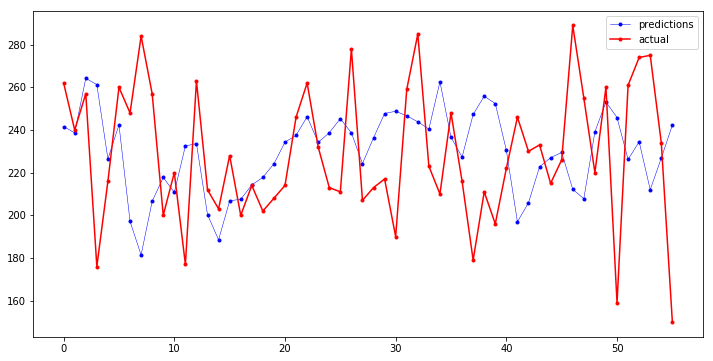

In [83]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(range(len(y_test)), y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(range(len(y_test)), y_test, 'r.-', label='actual')
ax.legend()

In [85]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_pred,y_test)

1582.7276111943272

In [61]:
import pickle
import datetime as dt
print(dt.datetime.now().hour,dt.datetime.now().minute)

17 54


In [67]:
filename='models/lstm_7_{}_{}'.format(dt.datetime.now().day,dt.datetime.now().minute)
# pickle.dump(model, open('models/lstm_7_1', 'wb'))
filename

'models/lstm_7_23_7'

In [66]:
model.save(filename)

#### next try

In [17]:
model = keras.Sequential()
model.add(keras.layers.LSTM(32, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(32, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(32, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=32, epochs=1000)

Train on 428 samples
Epoch 1/1000
428/428 [==============================] - 4s 10ms/sample - loss: 62454.2150
Epoch 2/1000
428/428 [==============================] - 1s 3ms/sample - loss: 60661.2888
Epoch 3/1000
428/428 [==============================] - 1s 3ms/sample - loss: 59993.5739
Epoch 4/1000
428/428 [==============================] - 1s 3ms/sample - loss: 59575.9855
Epoch 5/1000
428/428 [==============================] - 1s 3ms/sample - loss: 59256.7818
Epoch 6/1000
428/428 [==============================] - 1s 3ms/sample - loss: 58984.8113
Epoch 7/1000
428/428 [==============================] - 1s 3ms/sample - loss: 58733.3408
Epoch 8/1000
428/428 [==============================] - 1s 3ms/sample - loss: 58495.8727
Epoch 9/1000
428/428 [==============================] - 1s 3ms/sample - loss: 58265.2848
Epoch 10/1000
428/428 [==============================] - 1s 3ms/sample - loss: 58038.8558
Epoch 11/1000
428/428 [==============================] - 1s 3ms/sample - loss: 57815.93

In [18]:
y_pred = model.predict(x_test)
y_pred[:5]

array([[249.86105],
       [249.86105],
       [249.86105],
       [249.86105],
       [249.86105]], dtype=float32)

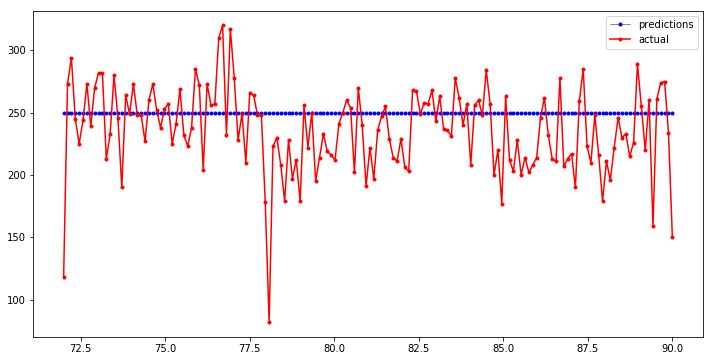

In [19]:
n_pts = len(acc_nr_bw)
t = np.linspace(0, 15 * 6, n_pts)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t[-len(y_test):], y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(t[-len(y_test):], y_test, 'r.-', label='actual')
ax.legend()